# Natural Language Processing for Chemistry: Integrating Language and Molecules for Drug Design

This tutorial will have 4 steps:
1. Generating molecules using natural language
2. Designing a drug using natural language. 
3. Language-guided Assay Testing
4. Docking Prediction

In [1]:

import os
import json
import torch
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration, BeamSearchScorer

import pickle


import os
import io

from collections import defaultdict

from rdkit import Chem
from rdkit.Chem.AllChem import GenerateDepictionMatching3DStructure
from rdkit.Chem.Draw import MolToFile
from rdkit.Chem.Draw import rdMolDraw2D

from PIL import Image

import cairosvg
from svglib import svglib
from reportlab.graphics.shapes import Drawing
from reportlab.graphics.renderSVG import SVGCanvas, draw

import IPython.display
from IPython.display import display

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from ipywidgets import interact, interactive, fixed

import clamp

from dockstring import load_target


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## 0. Generating molecules with with desired properties in natural language.

First, we will try generating molecules which can do certain functions. Here, we're going to use a pretrained MolT5-large model to generate new molecules. We'll generate diverse outputs using [Diverse Beam Search](https://arxiv.org/pdf/1610.02424.pdf).

To do this, we're going to use a sequence to sequence neural network trained to generate SMILES strings from natural language: MolT5. 

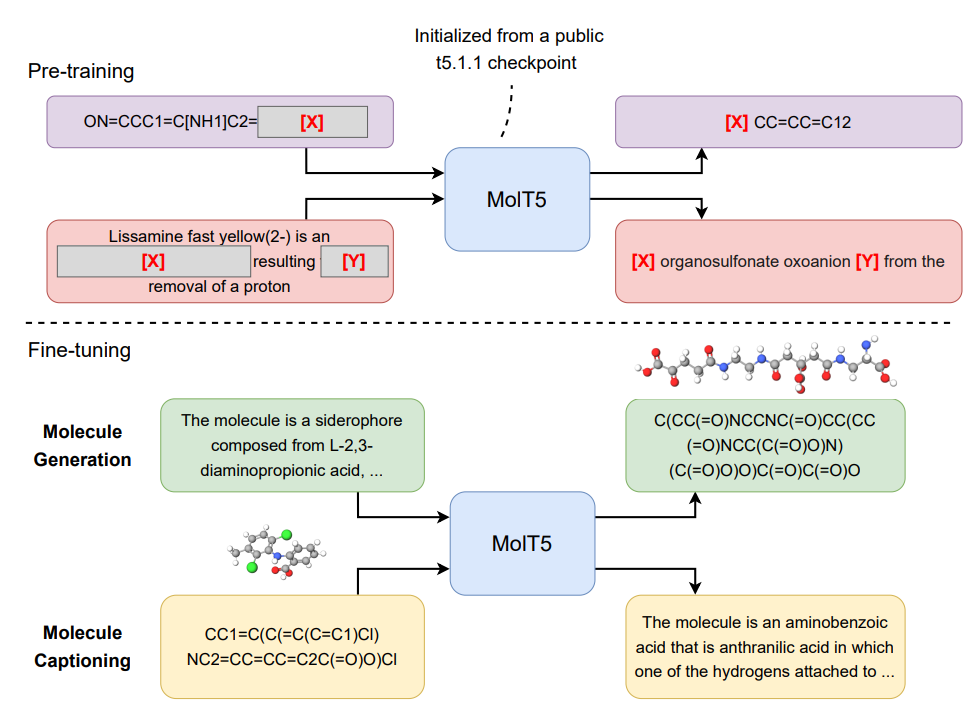

In [2]:

#Ok, let's load the model from Huggingface and generate some molecules! Here's some code for that.

BS = 20 #beam size
BG = BS #beam groups

#In this example, we're going to have the same number of diverse groups as we have beams in our decoding. 


MODEL_NAME = 'laituan245/molt5-large-caption2smiles'

# Helper function
def split_list_into_parts(l, max_size):
    parts = []
    while len(l) > max_size:
        parts.append(l[:max_size])
        l = l[max_size:]
    parts.append(l)
    return parts

def batch_generate(model, tokenizer, all_input_strs):
        all_input_strs = split_list_into_parts(all_input_strs, 1)
        all_outputs = {}
        for ix, input_strs in enumerate(all_input_strs):
            print('Generating Prompt:', ix)

            generated_strings = generate_from_strs(model, tokenizer, input_strs)
            all_outputs[input_strs[0]] = generated_strings
        return all_outputs

def generate_from_strs(model, tokenizer, input_strs):
    model_inputs = tokenizer(
        input_strs, max_length=512,
        padding=True, truncation=True, return_tensors='pt'
    )
    # Generation
    with torch.no_grad():

        tmp_BS = BS
        
        #Some larger beam searches are memory intensive, so I've written the code to reduce the beam size if a generation fails. 
        worked = False
        while not worked:
            try:
                outputs = model.generate(
                    input_ids=model_inputs['input_ids'].to(model.device),
                    max_length=512,
                    return_dict_in_generate=True,
                    output_scores=True,
                    num_beams=tmp_BS,
                    num_beam_groups = tmp_BS,
                    num_return_sequences=tmp_BS,
                    diversity_penalty = 0.5
                )
                worked = True
            except RuntimeError:
                tmp_BS = tmp_BS - 5
                print('Reduced beam size:', tmp_BS)
                
        generated_ids = outputs['sequences']
        generated_texts = tokenizer.batch_decode(
            generated_ids,
            skip_special_tokens=True
        )
        return generated_texts



#Let's create our model and tokenizer.
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=512)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).cuda()



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:

#Here are some example prompts. Feel free to add your own!
prompts = [
'The molecule is a blue dye.',
'The molecule is a red dye.',
'The molecule is an antineoplastic agent.',
'The molecule is a sulfonated xanthene.',
'The molecule is a corticosteroid.',
'The molecule is a polypeptide.',
'The molecule is an antitubercular agent.',
'The molecule is an anti-inflammatory agent.',
'The molecule is a fluorochrome.',
'The molecule is an antidepressant.',
'The molecule is a neurotransmitter agent.',
]


all_inputs = []
all_original_preds = []

all_outputs = batch_generate(model, tokenizer, prompts)

print(all_outputs)


Generating Prompt: 0
Generating Prompt: 1
Generating Prompt: 2
Generating Prompt: 3
Generating Prompt: 4
Generating Prompt: 5
Generating Prompt: 6
Generating Prompt: 7
Generating Prompt: 8
Generating Prompt: 9
Generating Prompt: 10
{'The molecule is a blue dye.': ['CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=CC(=C(C=C3S(=O)(=O)O)S(=O)(=O)O)O', 'CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=CC(=C(C=C3S(=O)(=O)O)S(=O)(=O)O)O', 'CCN1/C(=C/C(=C/C2=[N+](C3=C(S2)C=CC4=CC=CC=C43)CC)/C)/SC5=C1C6=CC=CC=C6C=C5', 'CCNC1=CC2=C(C=C1C)C(=C3C=C(C(=[NH+]CC)C=C3O2)C)C4=CC=CC=C4C(=O)OCC', 'C1=CC(=NC2=CC=C(C=C2)C(=O)O)C3=CC(=C(C=C3S(=O)(=O)O)S(=O)(=O)O)O', 'CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=CC(=C(C=C3S(=O)(=O)O)S(=O)(=O)O)O', 'COC(=O)C1=CC=CC=C1C2=C3C=CC(=[NH2+])C=C3OC4=C2C=CC(=C4)N', 'CN1C2=CC=CC=C2S/C1=CC3=CC=[N+](C=C3)CCC[N+](C)(C)C', 'CCN1/C(=C/C(=C/C2=[N+](C3=C(S2)C=CC4=CC=CC=C43)CC)/C)/SC5=C1C6=CC=CC=C6C=C5', 'CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=CC(=C(C=C3S(=O)(=O)O)S(=O)(=O

Let's plot these molecules!

The molecule is a blue dye.


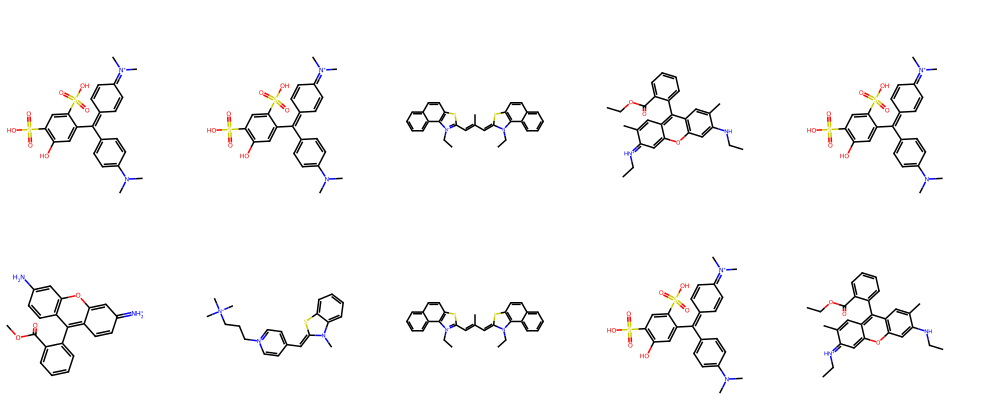

The molecule is a red dye.


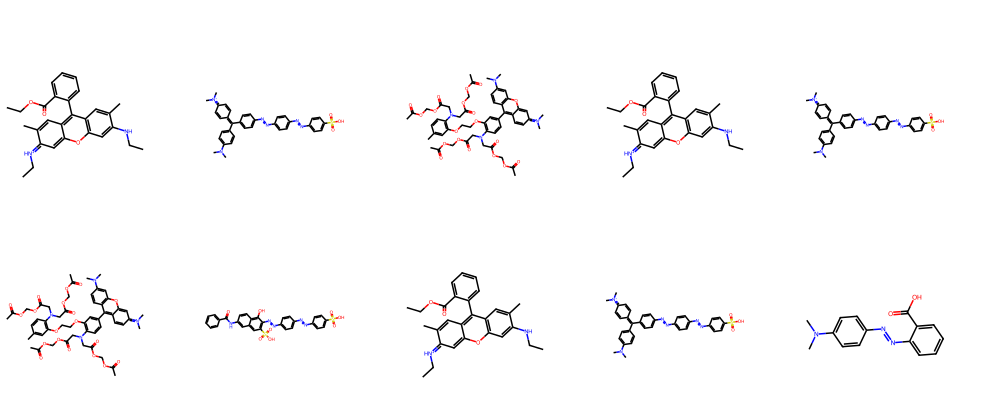

The molecule is an antineoplastic agent.


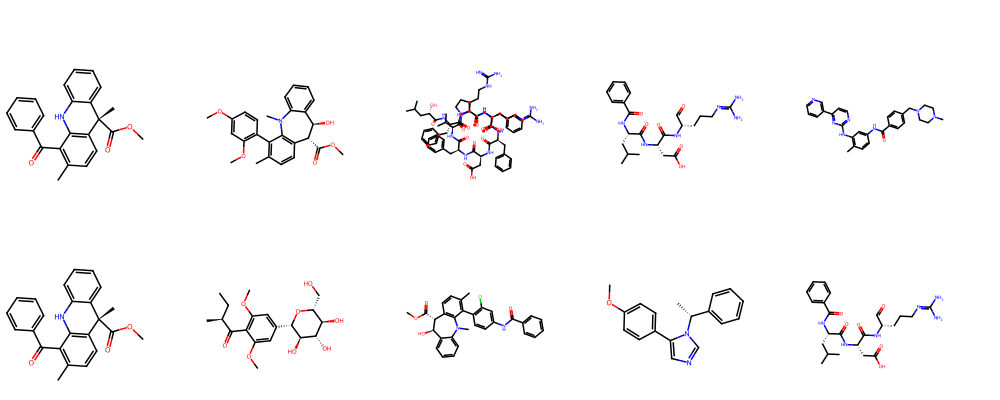

The molecule is a sulfonated xanthene.


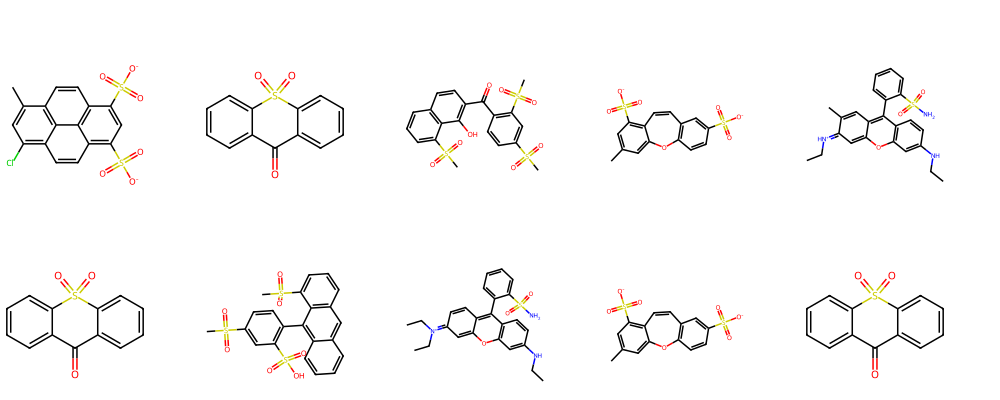

The molecule is a corticosteroid.


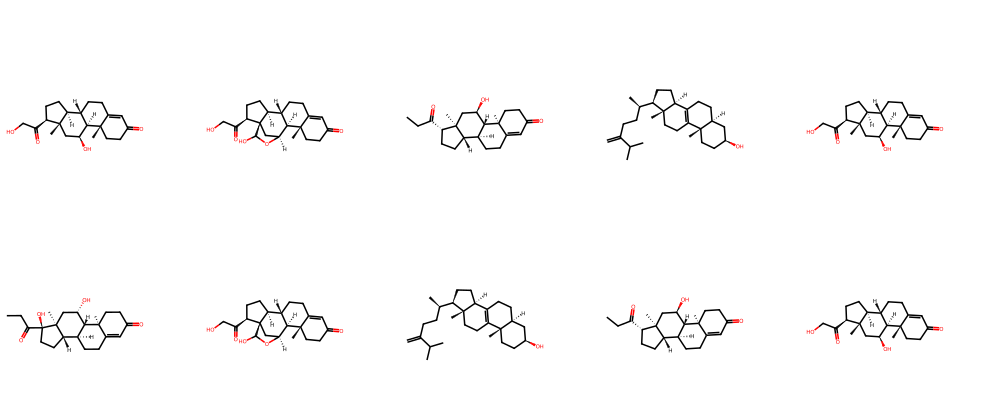

The molecule is a polypeptide.


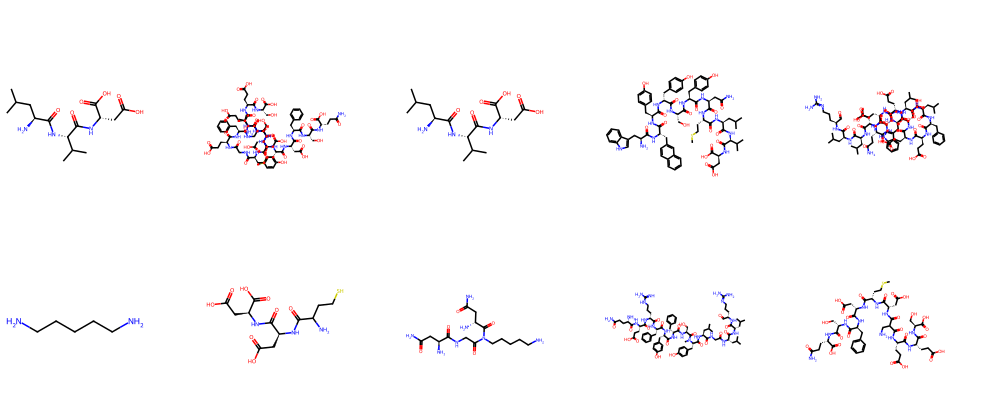

The molecule is an antitubercular agent.


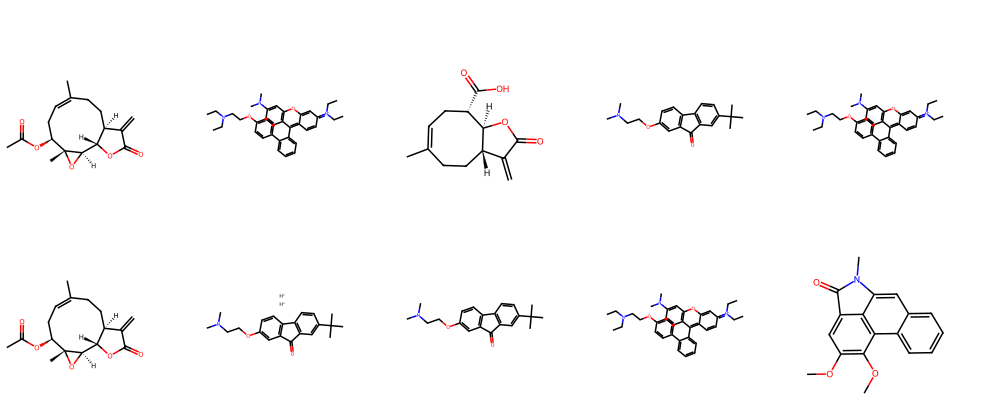

The molecule is an anti-inflammatory agent.


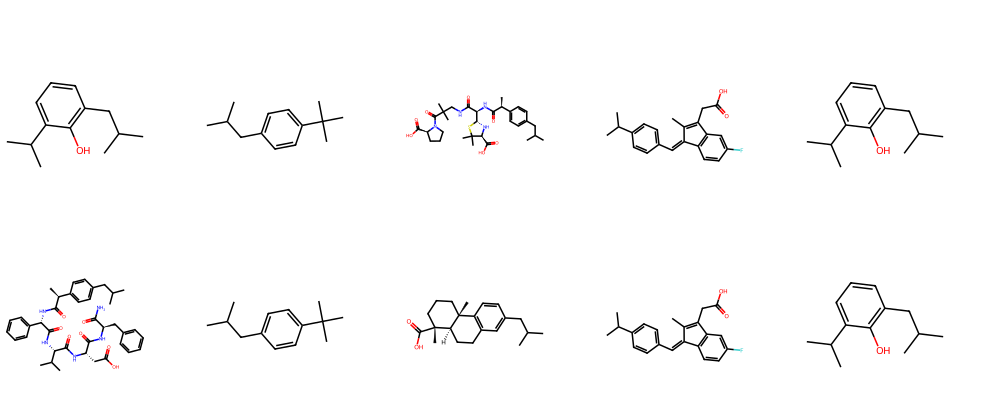

The molecule is a fluorochrome.


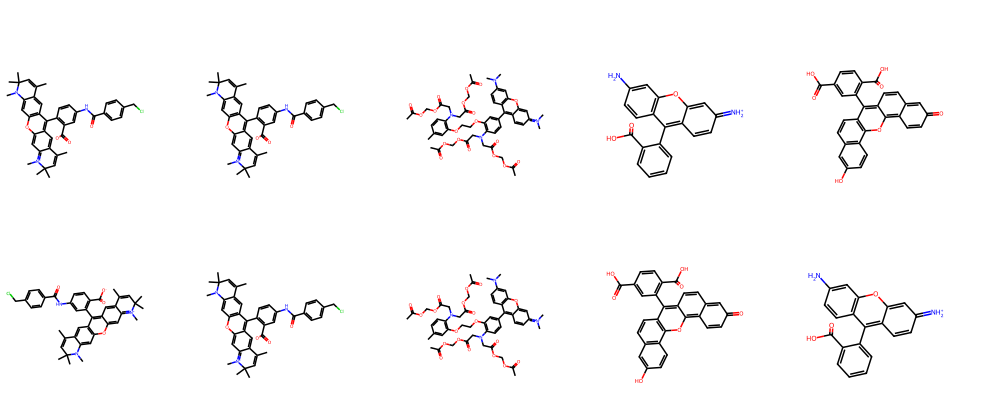

The molecule is an antidepressant.


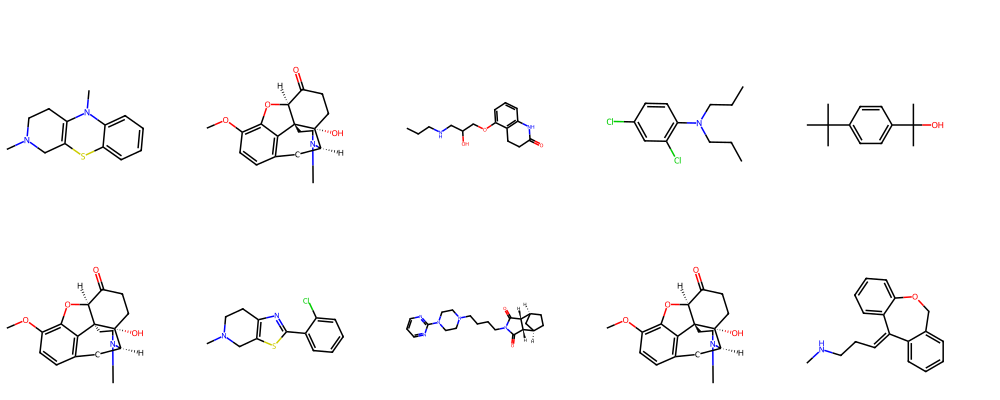

The molecule is a neurotransmitter agent.


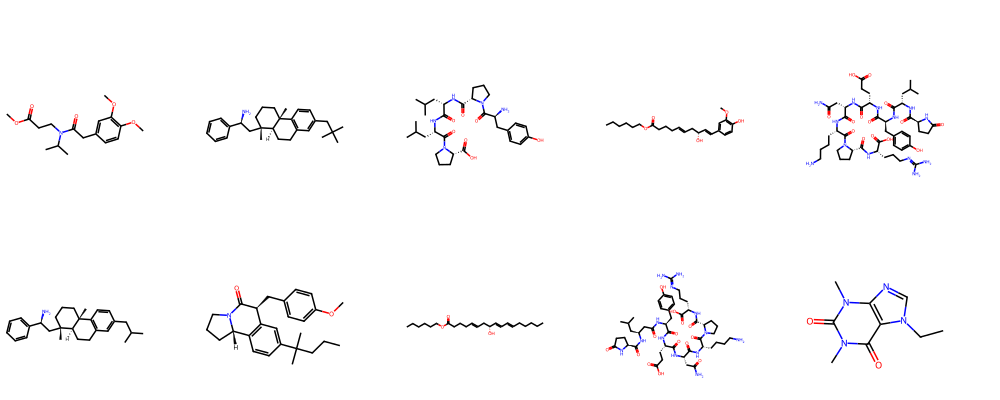

In [5]:

#Grid size for plotting molecules
w_mol = 5
h_mol = 2
k = w_mol * h_mol

#This dictionary will hold the topk valid molecules images which we can draw.  
topk = defaultdict(list)

#Image resolution for plotting molecules
h = 200
w = 200

for inp in all_outputs:
    #Let's first create an image for each 
    for i, smi in enumerate(all_outputs[inp]):

        mol = Chem.MolFromSmiles(smi)
        if mol == None: #Not all generated molecules are valid in RDKit!
            continue
        mol = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=True)
        drawer = rdMolDraw2D.MolDraw2DSVG(w, h)
        opts = drawer.drawOptions()
        drawer.SetLineWidth(2)

        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText()

        if len(topk[inp]) < k:
            topk[inp].append(svg)

    #Now, let's convert those svg files onto one common canvas.
    d = Drawing(w * w_mol, h * h_mol)
    for i, svg in enumerate(topk[inp]):
        cairosvg.svg2svg(svg, write_to='tmp.svg') #Writing to disk sidesteps a weird encoding problem in the library
        svg_element = svglib.svg2rlg("tmp.svg")
        svg_element.translate((i % w_mol)*w, h-(i//w_mol)*h)
        d.add(svg_element)

    #Finally, we can plot the canvas.
    s = io.StringIO()
    c = SVGCanvas((d.width, d.height))
    draw(d, c, 0, 0)
    c.save(s)
    canvas_svg = s.getvalue()

    print(inp)
    display(IPython.display.Image(cairosvg.svg2png(canvas_svg)))


## 1. Generating a molecule targeting microtubule stabilization. 

Microtubules are cellular structures which play an important role in many processes such cell growth and division, and mutations can be oncogenic. In modern medicine, tumors such as pancreatic cancer are commonly treated by microtubule-targeting drugs such as paclitaxel (commonly called Taxol). In our example, we will explore creating new drugs with the same function as Taxol using natural language instructions. Having drugs with the same function may be useful in cases of paclitaxel resistance.

Now, let's generate a molecule which matches our goal. Feel free to modify the prompt to your own taste!

In [7]:
prompt = ["The molecule is a microtubule stabilizer similar to Taxol. This causes it to display antineoplastic activity."]

candidates = batch_generate(model, tokenizer, prompt)
print(candidates)

#Ok, we now have SMILES strings. Let's convert these to Molecule objects from RDKit, a commonly used library in cheminformatics.
mols = [Chem.MolFromSmiles(c) for c in candidates[prompt[0]]]

#When RDKit processes invalid SMILES strings, it returns None. This allows us to remove bad generations.
valid_mols = [m for m in mols if m != None]

#Now, we'll process our molecules so we only keep unique candidate graphs.
un_valid_mols = [Chem.MolFromSmiles(c) for c in set([Chem.MolToSmiles(c) for c in valid_mols])]


Generating Prompt: 0
{'The molecule is a microtubule stabilizer similar to Taxol. This causes it to display antineoplastic activity.': ['CC1=C(C2=C(CCC(O2)(C)COC3=CC=C(C=C3)CC4C(=O)NC(=O)S4)C(=C1O)C)C', 'CC1=C2C(=C(C(=C1O)C(=O)NCC(C)(C)C)NC(=O)[C@@H]([C@H](C)N)O)C(=O)C3=C(C2=O)C(=CC=C3)O', 'CC1=C2[C@H](C(=O)N(C(=O)N2C3=CC=CC=C3)C4=CC=CC=C4)C5=C(C=C(C=C5)OC)O', 'C[C@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H]([NH2+]C3)C(=O)NC4=CC=CC(=C4)C(=O)[O-])C(=O)[O-])[C@@H](C)O', 'CC1=C(C2=C(CCC(O2)(C)COC3=CC=C(C=C3)CC4C(=O)NC(=O)S4)C(=C1O)C)C', 'CC1=C(C2=C(C=C1)[C@@](C3=CC(=C(C(=C3C2=O)C)C(C)(C)C)CC=C(C)C)O)(C)C', 'CC1=C2[C@H](C(=O)N(C(=O)N2C3=CC=CC=C3)C4=CC=CC=C4)C5=C(C=C(C=C5)OC)O', 'CC1=C(C2=C([C@H]([C@@]3(N2C[C@H]4[C@@H]3N4)OC)COC(=O)C5=CC=CC=C5)C(=O)OC)O', 'CC[C@H](C)C(=O)C1=C(C=C(C=C1O)O)O', 'CC1=C(C2=C(CCC(O2)(C)COC3=CC=C(C=C3)CC4C(=O)NC(=O)S4)C(=C1O)C)C', 'CC1=C2[C@H](C(=O)N(C2=O)C)NC(=O)[C@@H](C3=CC=CC=C3)N', 'CC1=C2[C@H](C(=O)N(C(=O)N2C3=CC=CC=C3)C4=CC=CC=C4)C5=C(C=C(C=C5)OC)O', 'CC1=C(C2

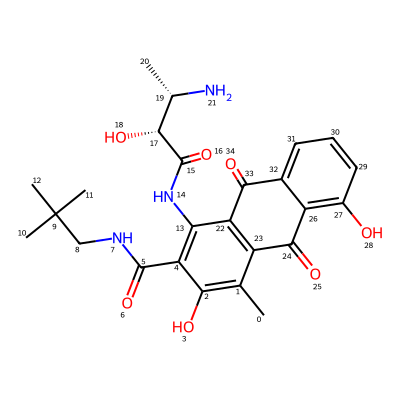

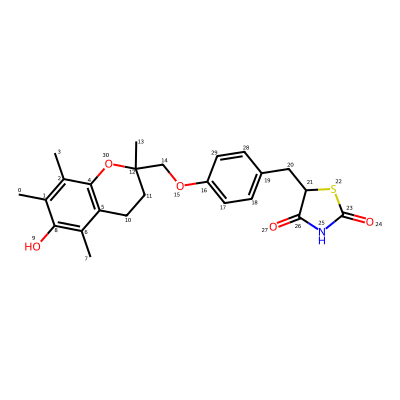

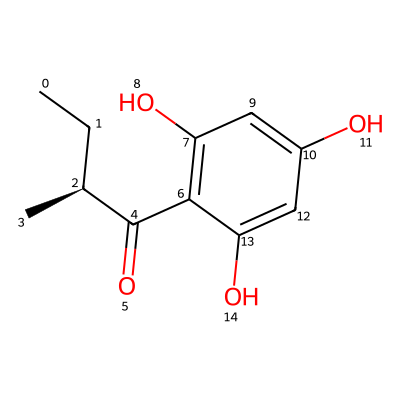

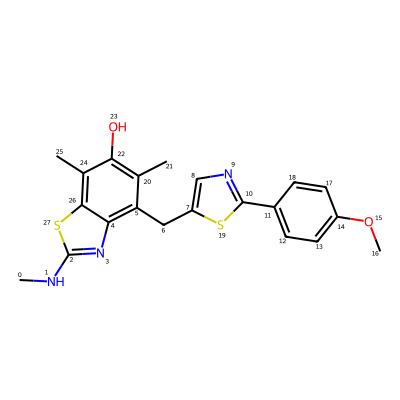

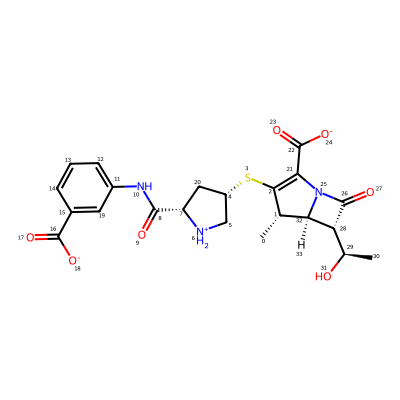

In [8]:

#Now, we'll plot all the unique, valid molecules which we generated.

def draw_mol(mol, file_name = 'tmp.png'):
    d = rdMolDraw2D.MolDraw2DCairo(400, 400) # or MolDraw2DSVG to get SVGs
    d.drawOptions().addAtomIndices = True
    if isinstance(mol, list):
        d = Draw.MolsToGridImage(mol)
        d.save(file_name)
        return
    else: d.DrawMolecule(mol)
    d.FinishDrawing()
    #d.WriteDrawingText(file_name)
    return d.GetDrawingText()

for m in un_valid_mols:
    display(IPython.display.Image(draw_mol(m)))




In actual drug discovery, it's important for us to understand the 3D generation of the molecule. Let's visualize the first 3 of our candidates in 3D:
(note that this is an approximation). 

In [9]:

#This function and code will create an interactive widget using py3Dmol!
def drawit(m,p,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

first3 = un_valid_mols[:3]

for m in first3:

    m = Chem.AddHs(m)
    AllChem.EmbedMultipleConfs(m,numConfs=10,randomSeed=0xf00d,useExpTorsionAnglePrefs=True,\
                           useBasicKnowledge=True)

    # now construct the view and interactive widget:
    p = py3Dmol.view(width=400,height=400)

    interact(drawit, m=fixed(m),p=fixed(p),confId=(0,m.GetNumConformers()-1));

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

## 2. Use Language Models to Predict In Silico Laboratory Tests (Assays)

Ok, now let's test our desired molecule's properties using a new method: [CLAMP](https://arxiv.org/abs/2303.03363). 

In lab testing, assays are often used to determine molecular properties before moving to expensive animal testing.
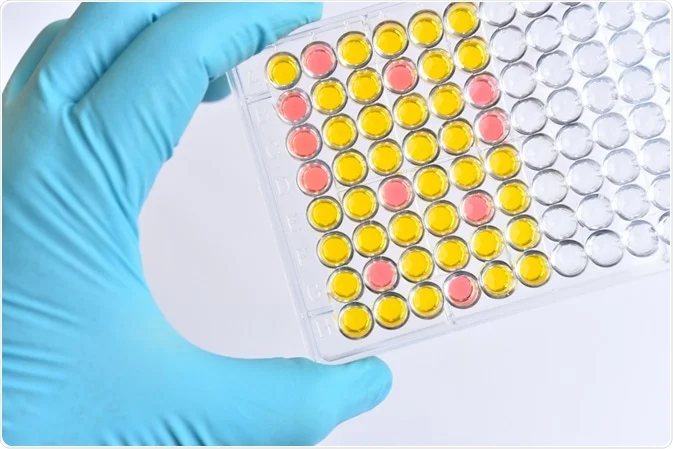!

(from azolifesciences.com)

In CLAMP, a model is trained to predict assay behavior based on a natural language description. This means it can do zero-shot assay prediction!
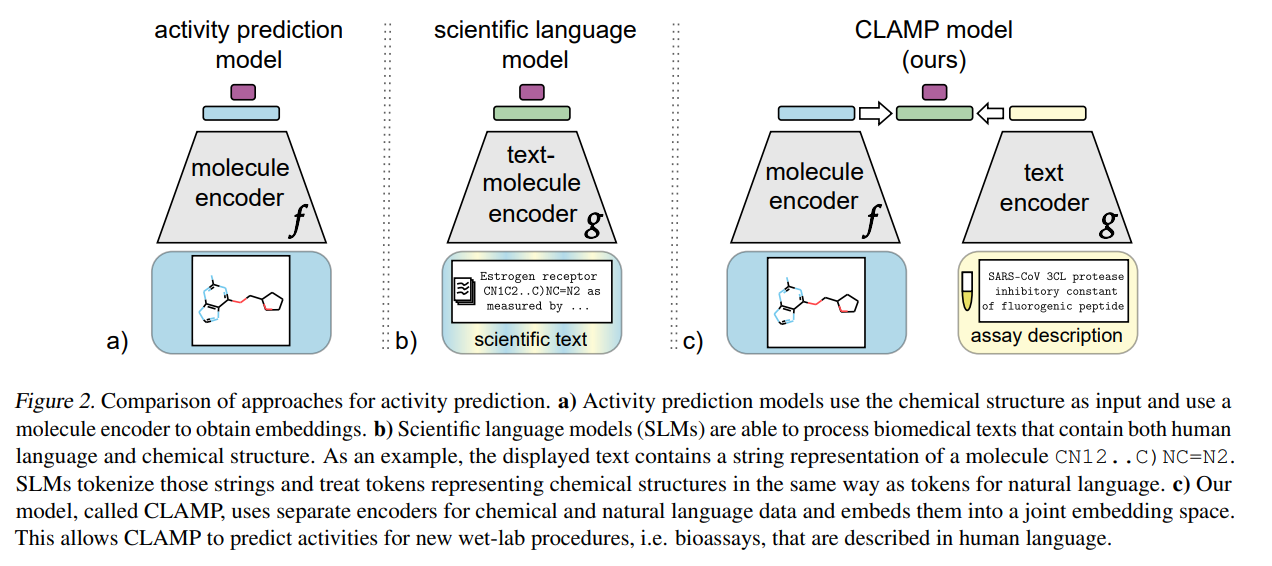


In [10]:
#Let's also look at our known baseline for this problem, Taxol (https://en.wikipedia.org/wiki/Paclitaxel):
taxol = 'CC1=C2[C@@]([C@]([C@H]([C@@H]3[C@]4([C@H](OC4)C[C@@H]([C@]3(C(=O)[C@@H]2OC(=O)C)C)O)OC(=O)C)OC(=O)c5ccccc5)(C[C@@H]1OC(=O)[C@H](O)[C@@H](NC(=O)c6ccccc6)c7ccccc7)O)(C)C'

m = Chem.AddHs(Chem.MolFromSmiles(taxol))
AllChem.EmbedMultipleConfs(m,numConfs=10,randomSeed=0xf00d,useExpTorsionAnglePrefs=True,\
                        useBasicKnowledge=True)

# now construct the view and interactive widget:
p = py3Dmol.view(width=400,height=400)

interact(drawit, m=fixed(m),p=fixed(p),confId=(0,m.GetNumConformers()-1));

interactive(children=(IntSlider(value=0, description='confId', max=9), Output()), _dom_classes=('widget-intera…

In [12]:
#Now, let's look at what activity CLAMP predicts.

model = clamp.CLAMP(device='cpu')
model.eval()

assay_descriptions = [
    'Inhibition of tubulin polymerization.',
    ]

molecules =  [taxol] + [Chem.MolToSmiles(mol) for mol in un_valid_mols] #We're going to test all our valid molecules and Taxol

with torch.no_grad():
    logits = model.forward_dense(molecules, assay_descriptions)
    probs = logits.softmax(dim=0).cpu().numpy() # probs for molecules

print("Mol logits for assay:", logits[:,0])
print("Mol probs for assay:", probs[:,0])

2024-02-01 13:52:29.369 | INFO     | clamp.models.pretrained:__init__:33 - Loaded pretrained model from data/models/clamp_clip/checkpoint.pt


Mol logits for assay: tensor([0.2840, 0.3505, 0.2665, 0.1972, 0.2990, 0.3474])
Mol probs for assay: [0.16532329 0.17669125 0.16245544 0.15157877 0.16782023 0.17613098]


## 3. Testing Docking Affinity

Now, we're going to test our candidate molecule's abilities to interact with microtubules. To do this, we'll use Dockstring. 

'''Molecular docking is a widely successful method in drug discovery that estimates a molecule's binding affinity to a protein: a mechanism which underlies the activity of most drugs. Docking normally requires significant domain knowledge to perform, which is why we made a python package to perform docking automatically. The result is a program which can reliably and reproducibly dock molecules from just their SMILES string in a single line of python code. We have used dockstring to create a dataset and to define several benchmarks which are more challenging and realistic than many current popular benchmarks (e.g. maximizing penalized logP or QED).'''
- [Dockstring](https://dockstring.github.io/)

From Wikipedia we can see how Taxol binds to the beta-tubulin subunits of microtubules (it's the yellow molecule): 

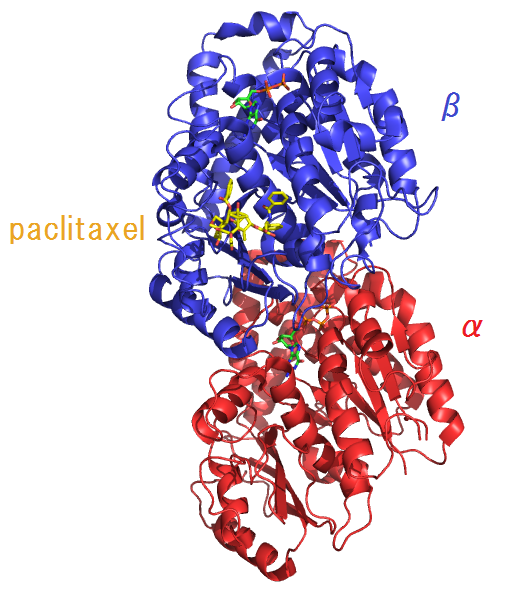

In particular, we'll look at Taxol's binding site on the beta-tubulin protein. This protein can be found at which we can find at https://www.rcsb.org/structure/2HXF

There are a few steps to prepare the protein for docking. Luckily, I've already imported it into DockString, but here are the steps I used:

1. Download 2hxf.pdb from RCSB.org
2. Delete the taxol ligand and save as 2hxf_dock.pdb.
3. Get taxol ligand coordinates from PyMol:
  3.1. xyz = cmd.get_coords('sele', 1)
  3.2. Take mean of xyz: [30.10645161, 18.18727419, 74.2565]
4. Convert to .pdbqt with openbabel: obabel .\2hxf_dock.pdb -O 2hxf_dock_target.pdbqt -p 7.4 -xr
5. cp 2hxf_dock_target.pdbqt /u/cne2/.local/lib/python3.9/site-packages/dockstring/resources/targets/
   cp 2hxf_dock_conf.txt /u/cne2/.local/lib/python3.9/site-packages/dockstring/resources/targets/
   

In [17]:

docking_scores = {}

#Let's load the target I prepared.
target = load_target('2hxf_dock')

#Dockstring takes a list of SMILES as input. Let's use RDKit to get our unique valid molecule's SMILES.
#We'll also test a simple ring since it will run faster and give us a baseline score. 
test_smis = ['C1CCCCC1'] + [Chem.MolToSmiles(mol) for mol in un_valid_mols]

print('In Docking Scores, the lower number is better!')

for smi in test_smis:
  score, aux = target.dock(smi)

  print(score, 'docking score with molecule', smi)

  docking_scores[smi] = score

  #target.view([aux['ligand']]) #This let's us visualize the docking position using PyMol.


In Docking Scores, the lower number is better!
-3.6 docking score with molecule C1CCCCC1
-7.6 docking score with molecule Cc1c(O)c(C(=O)NCC(C)(C)C)c(NC(=O)[C@H](O)[C@H](C)N)c2c1C(=O)c1c(O)cccc1C2=O
-9.2 docking score with molecule Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3=O)cc1)O2
-5.5 docking score with molecule CC[C@H](C)C(=O)c1c(O)cc(O)cc1O
-7.7 docking score with molecule CNc1nc2c(Cc3cnc(-c4ccc(OC)cc4)s3)c(C)c(O)c(C)c2s1
-8.2 docking score with molecule C[C@@H]1C(S[C@@H]2C[NH2+][C@H](C(=O)Nc3cccc(C(=O)[O-])c3)C2)=C(C(=O)[O-])N2C(=O)[C@H]([C@@H](C)O)[C@@H]12


Now let's test Taxol (this might time out).

In [44]:
score, aux = target.dock(taxol)

print(score, 'docking score with molecule', taxol)
#target.view([aux['ligand']])

-9.2 docking score with molecule CC1=C2[C@@]([C@]([C@H]([C@@H]3[C@]4([C@H](OC4)C[C@@H]([C@]3(C(=O)[C@@H]2OC(=O)C)C)O)OC(=O)C)OC(=O)c5ccccc5)(C[C@@H]1OC(=O)[C@H](O)[C@@H](NC(=O)c6ccccc6)c7ccccc7)O)(C)C


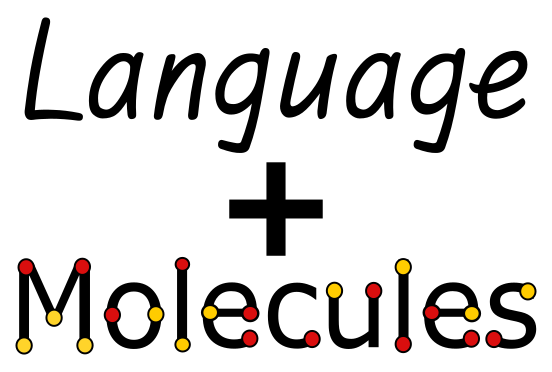

## Check out our workshop at ACL 2024!!! https://language-plus-molecules.github.io/